
# Atlas notebooks
--------------
----------
## Remote loading and model ensembles building of climate projection data in climate4R.

*08/07/2021*

**M. Iturbide** (Santander Meteorology Group. Institute of Physics of Cantabria, CSIC-UC, Santander, Spain).

> This notebook describes the generation of two NetCDFs that are included as auxiliary material in this repository: `notebooks/auxiliary-material/CMIP5_historical_pr.nc` and `notebooks/auxiliary-material/CMIP5_rcp85_pr.nc`. These files contain CMIP5 precipitation climatologies of a reduced set of models for the 1986-2005 and 2041-2060 periods respectively.

> This and other notebooks are available at https://github.com/IPCC-WG1/Atlas for reproducibility and reusability purpose.  


### 1. Load packages and functions
**Packages**:

In [ ]:
# Climate4R package for data loading
library(loadeR)
# Climate4R package for data visualization
# <https://doi.org/10.1016/j.envsoft.2017.09.008>
library(visualizeR)
# Dev utilities used for source_url
library(devtools)

**Functions**: 
In this notebook the `climate4R.chunk` function is used to perform climate data loading and temporal aggregation in the same step and by latitudinal chunks. This has the great advantage of avoiding the creation of heavy objects and making requests for small pieces of data in each iteration. This results in more efficient data loading and management. To load the function in the working environment use the `source` R base function as follows.

In [2]:
# Load function for latitudinal chunking 
source_url("https://github.com/SantanderMetGroup/climate4R/blob/devel/R/climate4R.chunk.R?raw=TRUE")

SHA-1 hash of file is feed646847e95e5c030a0949248ddfd5001a1ae4



### 2. Parameter setting 

Set the parameters of the different functions used in this notebook.

In [1]:
# Select number of chunks
# Note: chunking sequentially splits the task into manageable data chunks to avoid memory problems
# Chunking operates by spliting the data into a predefined number latitudinal slices (n=2 in this example).
# Further details: https://github.com/SantanderMetGroup/climate4R/tree/master/R 
n.chunks <- 2
# Index, scenario, season and reference and future period(s) of interest, e.g.:
var <- "pr"  # index (maximum temperature)
project <- "CMIP5"
scenario <- "rcp85"  # scenario
season <- c(12, 1, 2)  # (entire year: season = 1:12; boreal winter (DJF): season = c(12, 1, 2); boreal summer (JJA): season = 6:8, and so on...)
base.period <- 1986:2005
future.period <- 2041:2060
# The target region 
lonLim <- c(-10, 35)
latLim <- c(35, 75)

### 3. Extract and select the ensemble models



The function `UDG.datasets` returns the list of available datasets matching a pattern. Here the selected project and scenario is used as the search pattern (the historical data is also listed).

In [4]:
dataset.hist <- UDG.datasets(paste0(project, ".*historical"))
dataset.ssp <- UDG.datasets(paste0(project, ".*", scenario))

Matches found for: CMIP5_AR5_1run CMIP5_AR5 CMIP5_subset

Label names are returned, set argument full.info = TRUE to get more information

Matches found for: CMIP5_AR5_1run CMIP5_AR5 CMIP5_subset

Label names are returned, set argument full.info = TRUE to get more information



We select the set of models CMIP5_AR5_1run

In [5]:
dataset.hist <- dataset.hist[["CMIP5_AR5_1run"]]
dataset.ssp <- dataset.ssp[["CMIP5_AR5_1run"]]

Check the available models:

In [6]:
dataset.ssp

[1] "CMIP5_ACCESS1-0_r1i1p1_rcp85"      "CMIP5_ACCESS1-3_r1i1p1_rcp85"     
 [3] "CMIP5_bcc-csm1-1-m_r1i1p1_rcp85"   "CMIP5_bcc-csm1-1_r1i1p1_rcp85"    
 [5] "CMIP5_BNU-ESM_r1i1p1_rcp85"        "CMIP5_CanESM2_r1i1p1_rcp85"       
 [7] "CMIP5_CCSM4_r1i1p1_rcp85"          "CMIP5_CESM1-BGC_r1i1p1_rcp85"     
 [9] "CMIP5_CMCC-CESM_r1i1p1_rcp85"      "CMIP5_CMCC-CM_r1i1p1_rcp85"       
[11] "CMIP5_CMCC-CMS_r1i1p1_rcp85"       "CMIP5_CNRM-CM5_r1i1p1_rcp85"      
[13] "CMIP5_CSIRO-Mk3-6-0_r1i1p1_rcp85"  "CMIP5_EC-EARTH_r1i1p1_rcp85"      
[15] "CMIP5_FGOALS-g2_r1i1p1_rcp85"      "CMIP5_GFDL-CM3_r1i1p1_rcp85"      
[17] "CMIP5_GFDL-ESM2G_r1i1p1_rcp85"     "CMIP5_GFDL-ESM2M_r1i1p1_rcp85"    
[19] "CMIP5_HadGEM2-CC_r1i1p1_rcp85"     "CMIP5_HadGEM2-ES_r1i1p1_rcp85"    
[21] "CMIP5_inmcm4_r1i1p1_rcp85"         "CMIP5_IPSL-CM5A-LR_r1i1p1_rcp85"  
[23] "CMIP5_IPSL-CM5A-MR_r1i1p1_rcp85"   "CMIP5_IPSL-CM5B-LR_r1i1p1_rcp85"  
[25] "CMIP5_MIROC-ESM-CHEM_r1i1p1_rcp85" "CMIP5_MIROC-ESM_r1i1p1_rcp85"     
[27] "CMIP5_MIROC5_r1i1p1_rcp85"         "CMIP5_MPI-ESM-LR_r1i1p1_rcp85"    
[29] "CMIP5_MPI-ESM-MR_r1i1p1_rcp85"     "CMIP5_MRI-CGCM3_r1i1p1_rcp85"     
[31] "CMIP5_NorESM1-M_r1i1p1_rcp85"

For brevity we will only use the first 6 models. 

To ensure that we get the same ensemble of models for both the historical and the future scenario we define the model names as follows:

In [7]:
models <- gsub(paste0("_", scenario), "", dataset.ssp[1:6])
models

[1] "CMIP5_ACCESS1-0_r1i1p1"    "CMIP5_ACCESS1-3_r1i1p1"   
[3] "CMIP5_bcc-csm1-1-m_r1i1p1" "CMIP5_bcc-csm1-1_r1i1p1"  
[5] "CMIP5_BNU-ESM_r1i1p1"      "CMIP5_CanESM2_r1i1p1"

Search the position of each model in `dataset.hist` and `dataset.ssp` using function `grep` in a loop. Subsequently subset the corresponding datasets.

In [8]:
# Search the position of each model in dataset.hist and dataset.ssp using function grep in a loop.
model.ind.hist <- vapply(models, grep, numeric(length = 1), x = dataset.hist)
model.ind.ssp <- vapply(models, grep, numeric(length = 1), x = dataset.ssp)
# Subset the datasets.
dataset.hist <- dataset.hist[model.ind.hist]
dataset.ssp <- dataset.ssp[model.ind.ssp]
dataset.hist; dataset.ssp

[1] "CMIP5_ACCESS1-0_r1i1p1_historical"   
[2] "CMIP5_ACCESS1-3_r1i1p1_historical"   
[3] "CMIP5_bcc-csm1-1-m_r1i1p1_historical"
[4] "CMIP5_bcc-csm1-1_r1i1p1_historical"  
[5] "CMIP5_BNU-ESM_r1i1p1_historical"     
[6] "CMIP5_CanESM2_r1i1p1_historical"

[1] "CMIP5_ACCESS1-0_r1i1p1_rcp85"    "CMIP5_ACCESS1-3_r1i1p1_rcp85"   
[3] "CMIP5_bcc-csm1-1-m_r1i1p1_rcp85" "CMIP5_bcc-csm1-1_r1i1p1_rcp85"  
[5] "CMIP5_BNU-ESM_r1i1p1_rcp85"      "CMIP5_CanESM2_r1i1p1_rcp85"

Now we are sure that the same models (in the same order) are selected for both scenarios.

### 4. Load data

The original function for data loadin is `loadGridData`, however, if `climate4R.chunk` is used data loading is performed internally together with an additional `climate4R` function (`climatology` in this example). For more details of the use of `climate4R.chunk` go to the [*climate4R* github](https://github.com/SantanderMetGroup/climate4R/tree/devel/R).

`climate4R.chunk` is applied in a `lapply` loop to perform the same operation with each model:

In [ ]:
hist <- lapply(dataset.hist, function(i) 
    climate4R.chunk(n.chunks = n.chunks,
                        C4R.FUN.args = list(FUN = "climatology",
                                            grid = list(dataset = i, var = var)),
                        loadGridData.args = list(years = base.period, season = season, lonLim = lonLim, latLim = latLim)))

In [ ]:
ssp <- lapply(dataset.ssp, function(i) 
    climate4R.chunk(n.chunks = n.chunks,
                        C4R.FUN.args = list(FUN = "climatology",
                                            grid = list(dataset = i, var = var)),
                        loadGridData.args = list(years = future.period, season = season, lonLim = lonLim, latLim = latLim)))

### 5. Build the ensemble 
Interpolate (function `interpGrid`) to the common grid available in this repository and build the ensemble (function `bindGrid`):

In [ ]:
# Inerpolate
common.grid <- loadGridData("../reference-grids/land_sea_mask_2degree.nc4", var = "sftlf", lonLim = lonLim, latLim = latLim)
hist.i <- lapply(hist, function(i) interpGrid(i, getGrid(common.grid), method = "bilinear"))
ssp.i <- lapply(ssp, function(i) interpGrid(i, getGrid(common.grid), method = "bilinear"))
# Ensemble building
hist.ens <- bindGrid(hist.i, dimension = "member")
ssp.ens <- bindGrid(ssp.i, dimension = "member")

The output is a climate4R grid of the precipitation climatology that includes the `member` dimension (i.e. a multi-member grid):

In [8]:
str(ssp.ens)

List of 6
 $ Variable           :List of 2
  ..$ varName: chr "pr"
  ..$ level  : NULL
  ..- attr(*, "use_dictionary")= logi FALSE
  ..- attr(*, "description")= chr "Precipitation"
  ..- attr(*, "units")= chr "mm"
  ..- attr(*, "longname")= chr "pr"
  ..- attr(*, "daily_agg_cellfun")= chr "none"
  ..- attr(*, "monthly_agg_cellfun")= chr "none"
  ..- attr(*, "verification_time")= chr "none"
 $ Data               : num [1:6, 1:21, 1:23] 1.552 1.15 NaN 0.977 0.901 ...
  ..- attr(*, "dimensions")= chr [1:3] "member" "lat" "lon"
 $ xyCoords           :List of 2
  ..$ x: num [1:23] -9 -7 -5 -3 -1 1 3 5 7 9 ...
  ..$ y: num [1:21] 35 37 39 41 43 45 47 49 51 53 ...
  ..- attr(*, "projection")= chr "LatLonProjection"
  ..- attr(*, "resX")= num 2
  ..- attr(*, "resY")= num 2
 $ Dates              :List of 2
  ..$ start: chr "2040-12-01 12:00:00 GMT"
  ..$ end  : chr "2040-12-01 12:00:00 GMT"
 $ Members            : chr [1:6] "Member_1" "Member_2" "Member_3" "Member_4" ...
 $ InitializationDates:

Check the result of using `spatialPlot`:

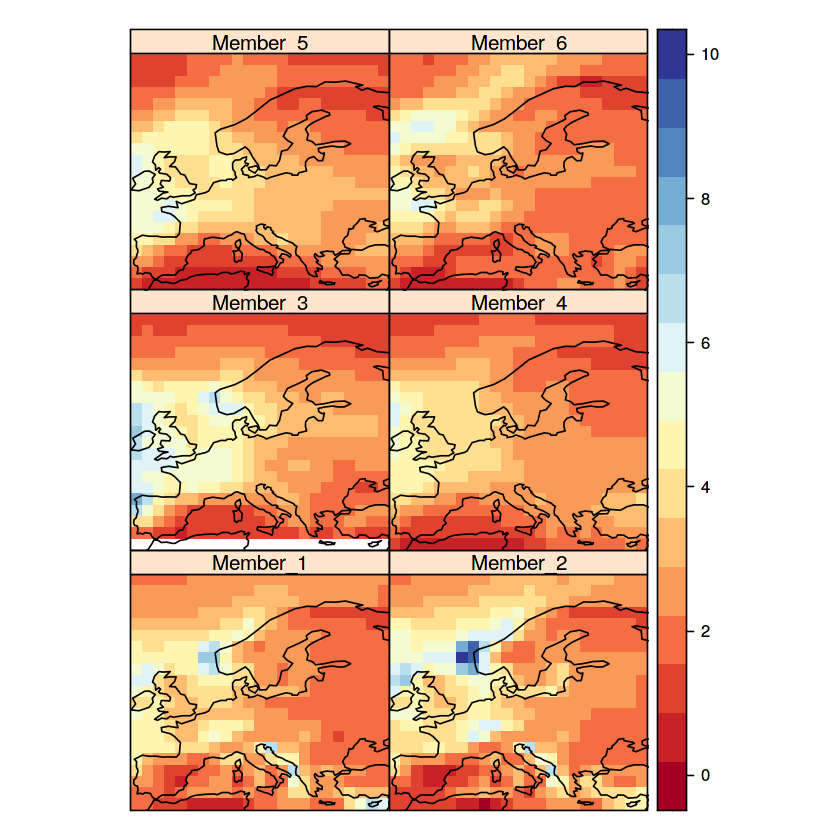

In [11]:
spatialPlot(ssp.ens, backdrop.theme = "coastline")

### 6. Export to NetCDF

In [ ]:
gri2nc(hist.ens, "auxiliary-material/CMIP5_historical_pr.nc")
gri2nc(ssp.ens, "auxiliary-material/CMIP5_rcp85_pr.nc")

### 7. Session Information

In [9]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 14.04.6 LTS

Matrix products: default
BLAS:   /usr/lib/libblas/libblas.so.3.0
LAPACK: /usr/lib/lapack/liblapack.so.3.0

locale:
 [1] LC_CTYPE=en_US.UTF-8          LC_NUMERIC=C                 
 [3] LC_TIME=es_ES.UTF-8           LC_COLLATE=en_US.UTF-8       
 [5] LC_MONETARY=es_ES.UTF-8       LC_MESSAGES=en_US.UTF-8      
 [7] LC_PAPER=es_ES.UTF-8          LC_NAME=es_ES.UTF-8          
 [9] LC_ADDRESS=es_ES.UTF-8        LC_TELEPHONE=es_ES.UTF-8     
[11] LC_MEASUREMENT=es_ES.UTF-8    LC_IDENTIFICATION=es_ES.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] devtools_2.3.0      usethis_1.6.0       visualizeR_1.6.0   
[4] transformeR_2.1.1   loadeR_1.7.0        climate4R.UDG_0.2.3
[7] loadeR.java_1.1.1   rJava_0.9-13       

loaded via a namespace (and not attached):
 [1] pkgload_1.0.2           maps_3.3.0            